 ## Milestone 3 - Exploratory Data Analysis

#### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
from db_utils import RDSDatabaseConnector
from classes import DataTransform
custloan_df = pd.read_csv(r'C:\Users\tde_v\CourseAI\customer_loans\loan_payments.csv')


#### 1. Convert columns to correct format
###### - These columns to be transformed as follows: 
###### employment_length - object to int64. ie. strings like '< 1 year', '2 years', '10+ years' to numeric values.


In [2]:
transform_employment_length = DataTransform(custloan_df)
transform_employment_length.convert_employment_to_numeric("employment_length")
print(transform_employment_length.df["employment_length"].head(10))

0     5.0
1     9.0
2     8.0
3     1.0
4    10.0
5     0.0
6     NaN
7     0.0
8     0.0
9    10.0
Name: employment_length, dtype: float64


#### Information from DataFrame

In [3]:
from classes import DataFrameInfo
df_info = DataFrameInfo(custloan_df)


#### Remove/impute missing values

In [4]:
from classes import DataFrameTransform
from classes import Plotter
df_transform = DataFrameTransform(custloan_df)
plotter = Plotter(custloan_df)

##### Determine amount of NULLs in each column

In [5]:
null_counts_before = custloan_df.isnull().sum()
df_info.null_value_summary()

NULL Value Summary:
                             Null Count  Null Percentage
funded_amount                      3007         5.544799
term                               4772         8.799395
int_rate                           5169         9.531449
employment_length                  2118         3.905515
mths_since_last_delinq            31002        57.166565
mths_since_last_record            48050        88.602460
last_payment_date                    73         0.134609
next_payment_date                 32608        60.127971
last_credit_pull_date                 7         0.012908
collections_12_mths_ex_med           51         0.094042
mths_since_last_major_derog       46732        86.172116




-- Decided to drop all columns with NULL percentage over 50.

In [6]:
df_transform.drop_high_null_columns(threshold=50)

Dropped columns with >50% NULLs: ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']



 -- Impute remaining NULLs

In [7]:
df_transform.impute_nulls()

Imputed column 'funded_amount' with mean.
Imputed column 'int_rate' with mean.
Imputed column 'employment_length' with mean.
Imputed column 'collections_12_mths_ex_med' with median.
Imputed column 'term' with mode: '36 months'.
Imputed column 'last_payment_date' with mode: 'Jan-2022'.
Imputed column 'last_credit_pull_date' with mode: 'Jan-2022'.




##### -- Re-run NULL checking

In [8]:
null_counts_after = custloan_df.isnull().sum()
df_info.null_value_summary()

NULL Value Summary:
Empty DataFrame
Columns: [Null Count, Null Percentage]
Index: []




##### - Visualise NULL removal

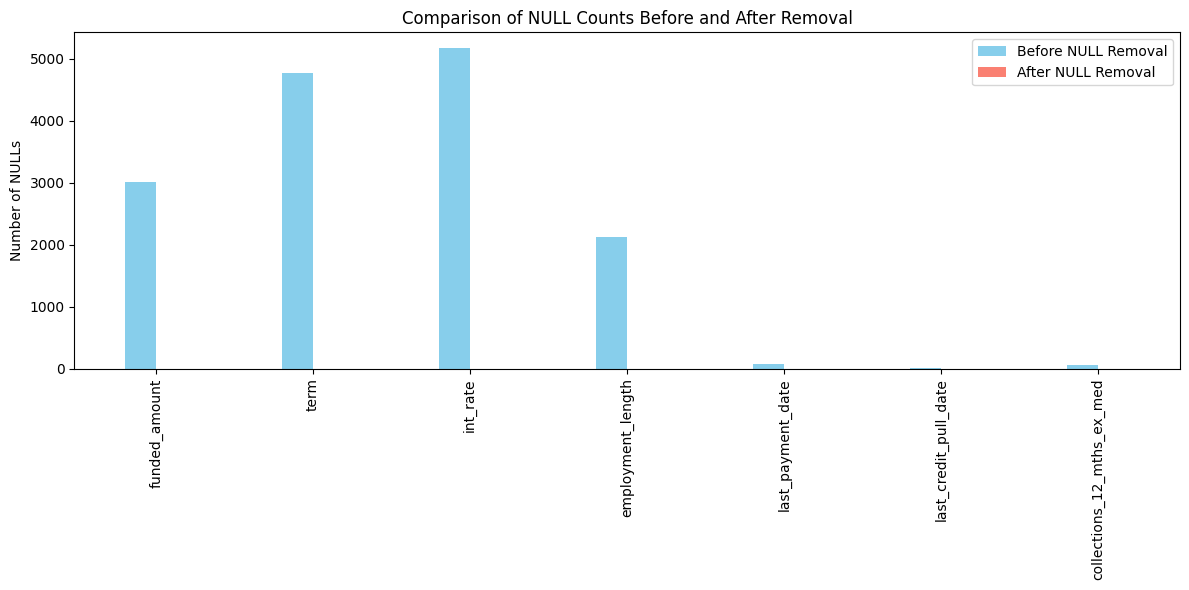

In [9]:
plotter.plot_nulls(null_counts_before, null_counts_after)

### Identify Skewed Columns

In [10]:
df_info.identify_skewed_columns(threshold=0)

Skewed Columns (>|0| skewness):
 - id: 2.370
 - member_id: 2.205
 - loan_amount: 0.805
 - funded_amount: 0.846
 - funded_amount_inv: 0.814
 - int_rate: 0.433
 - instalment: 0.997
 - employment_length: -0.118
 - annual_inc: 8.712
 - dti: 0.189
 - delinq_2yrs: 5.370
 - inq_last_6mths: 3.249
 - open_accounts: 1.059
 - total_accounts: 0.779
 - out_prncp: 2.356
 - out_prncp_inv: 2.357
 - total_payment: 1.268
 - total_payment_inv: 1.256
 - total_rec_prncp: 1.261
 - total_rec_int: 2.204
 - total_rec_late_fee: 13.184
 - recoveries: 14.590
 - collection_recovery_fee: 27.637
 - last_payment_amount: 2.499
 - collections_12_mths_ex_med: 20.262


##### - Set threshold as 1, disregard non-mathematical columns ('id' & 'member_id'), and visualise the skew.

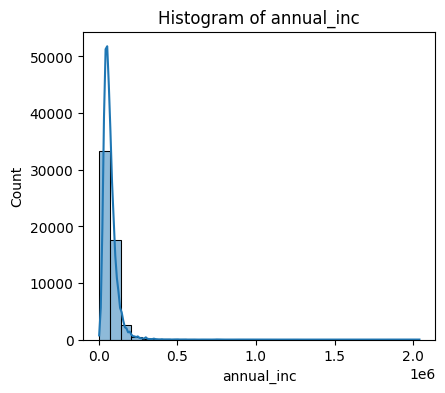

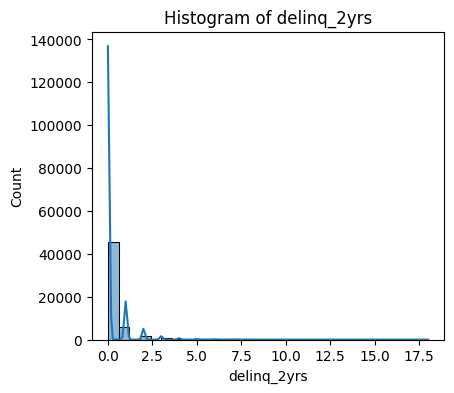

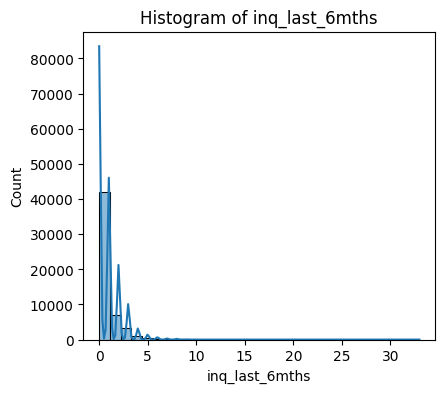

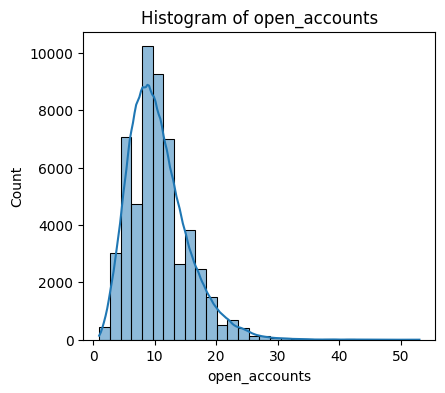

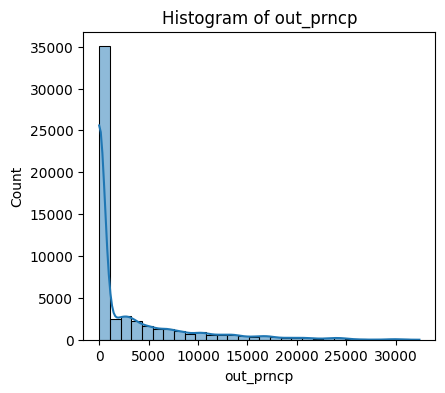

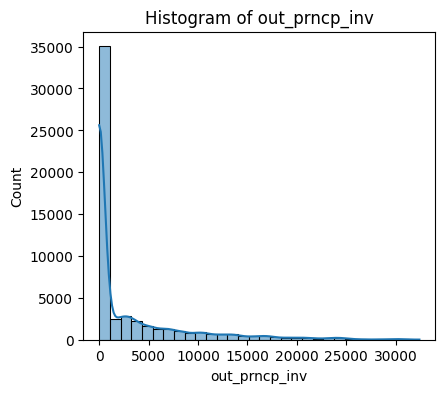

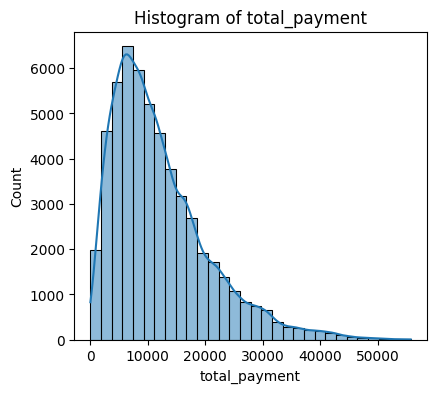

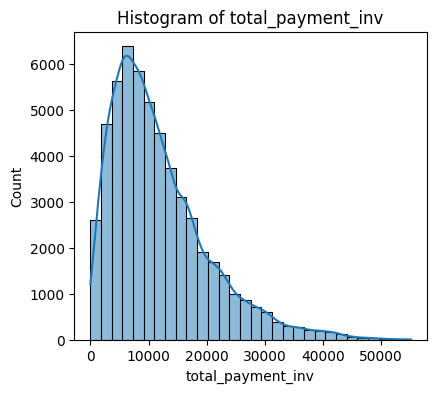

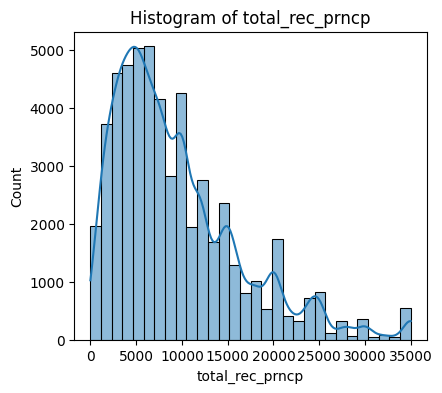

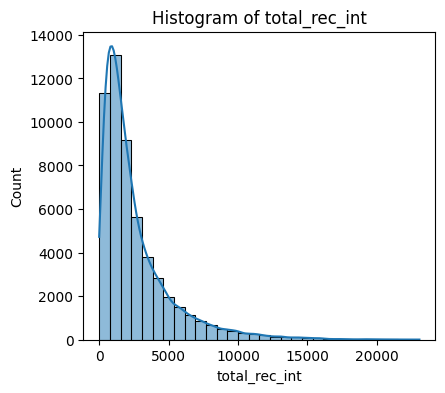

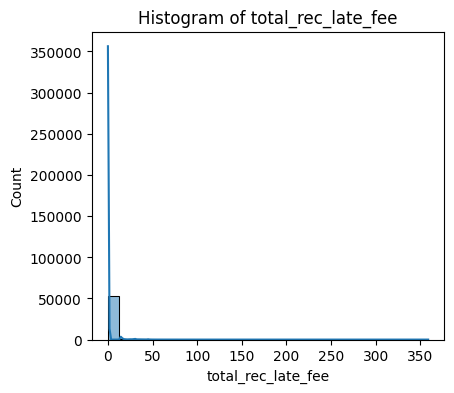

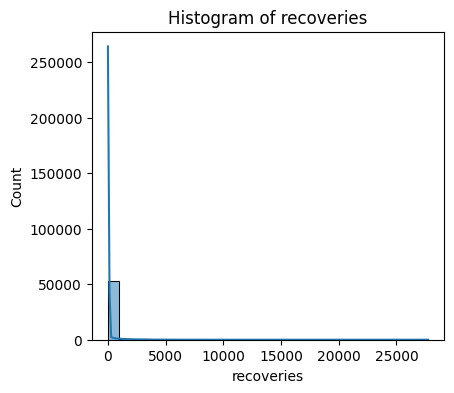

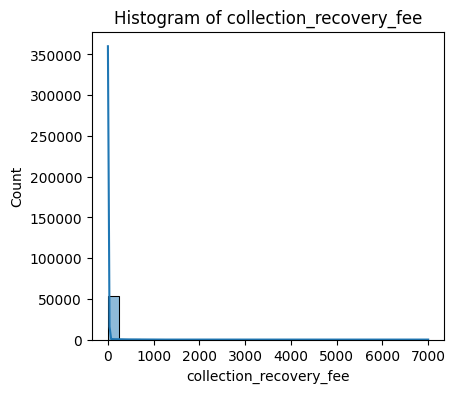

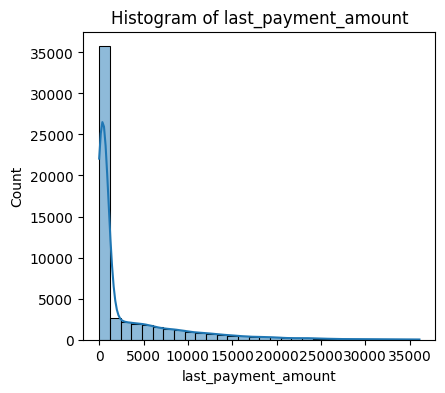

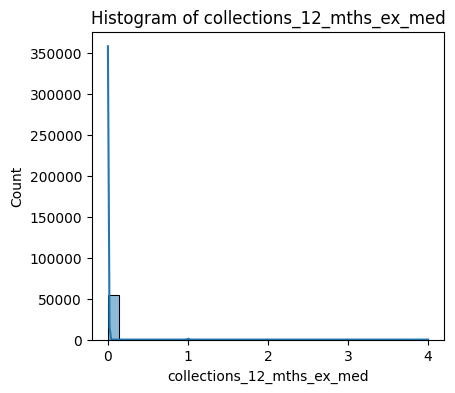

In [11]:
skewed_columns = plotter.plot_skew(threshold=1, exclude_cols=['id', 'member_id'])

##### --Transform columns to reduce skew, and visualise the results.

In [12]:
df_transform.transform_skewed_columns(threshold=1, exclude_cols=['id', 'member_id'])

Applied boxcox transformation to annual_inc. Skewness after: -0.011948183974555437
Applied boxcox transformation to open_accounts. Skewness after: 0.001819492598839149
Applied boxcox transformation to total_payment. Skewness after: -0.004029802680351841
Applied boxcox transformation to total_payment_inv. Skewness after: 0.004963861747204874
Applied boxcox transformation to total_rec_prncp. Skewness after: -0.004196163930908247
Applied boxcox transformation to total_rec_int. Skewness after: 0.020837071070294075
Applied boxcox transformation to last_payment_amount. Skewness after: -0.0017660827663652295




### Visualise Outliers

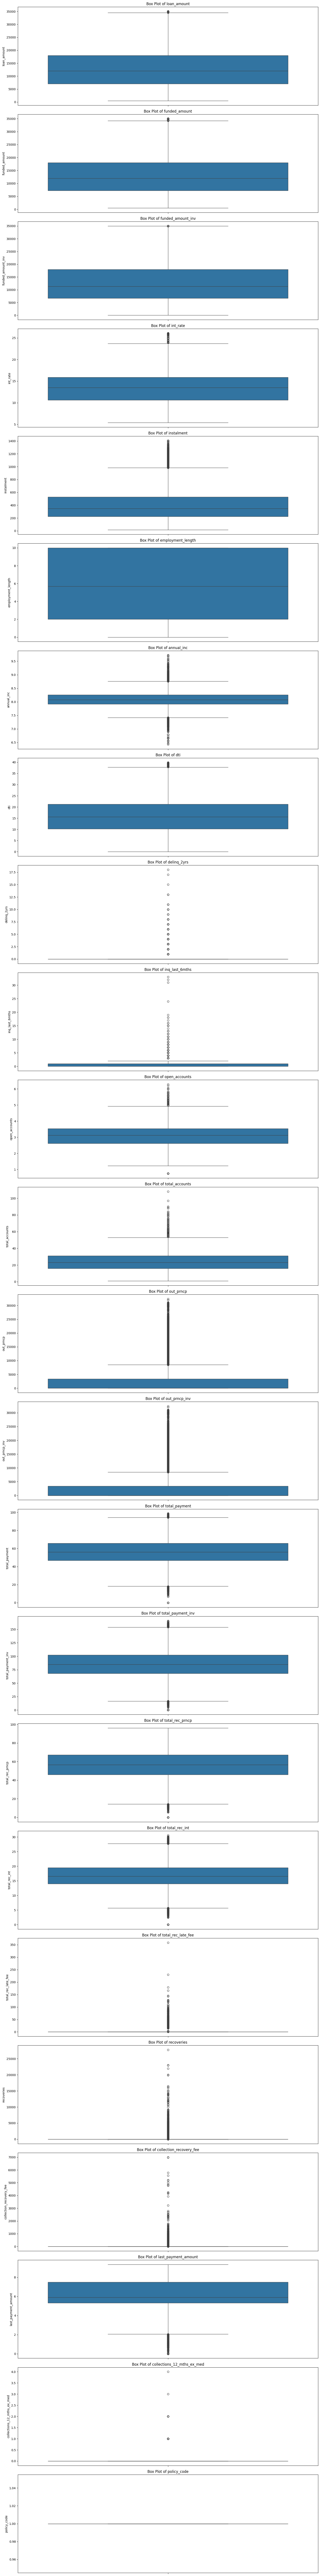

In [13]:
numeric_cols = custloan_df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['id', 'member_id']]
plotter.plot_outliers(numeric_cols)

##### - Remove outliers with IQR threashold of >1.5

In [14]:
df_transform.handle_outliers(method="remove", threshold=1.5)

Removed outliers from loan_amount.
Removed outliers from funded_amount.
Removed outliers from funded_amount_inv.
Removed outliers from int_rate.
Removed outliers from instalment.
Removed outliers from employment_length.
Removed outliers from annual_inc.
Removed outliers from dti.
Removed outliers from delinq_2yrs.
Removed outliers from inq_last_6mths.
Removed outliers from open_accounts.
Removed outliers from total_accounts.
Removed outliers from out_prncp.
Removed outliers from out_prncp_inv.
Removed outliers from total_payment.
Removed outliers from total_payment_inv.
Removed outliers from total_rec_prncp.
Removed outliers from total_rec_int.
Removed outliers from total_rec_late_fee.
Removed outliers from recoveries.
Removed outliers from collection_recovery_fee.
Removed outliers from last_payment_amount.
Removed outliers from collections_12_mths_ex_med.
Removed outliers from policy_code.


##### - Revisualise outliers

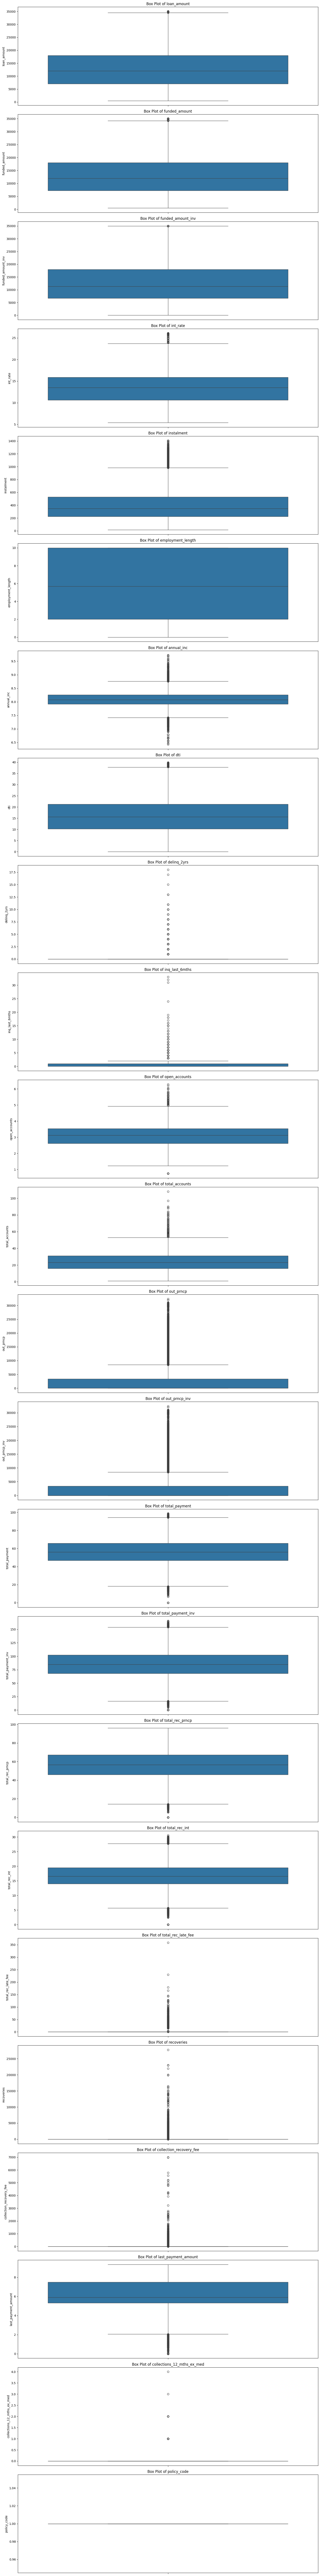

In [ ]:
numeric_cols = custloan_df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['id', 'member_id']]
plotter.plot_outliers(numeric_cols)
#re-do box plots from transform class.
# figure out column with mostly zero values.

### Overly Correlated Columns
##### - Visualise Correlation

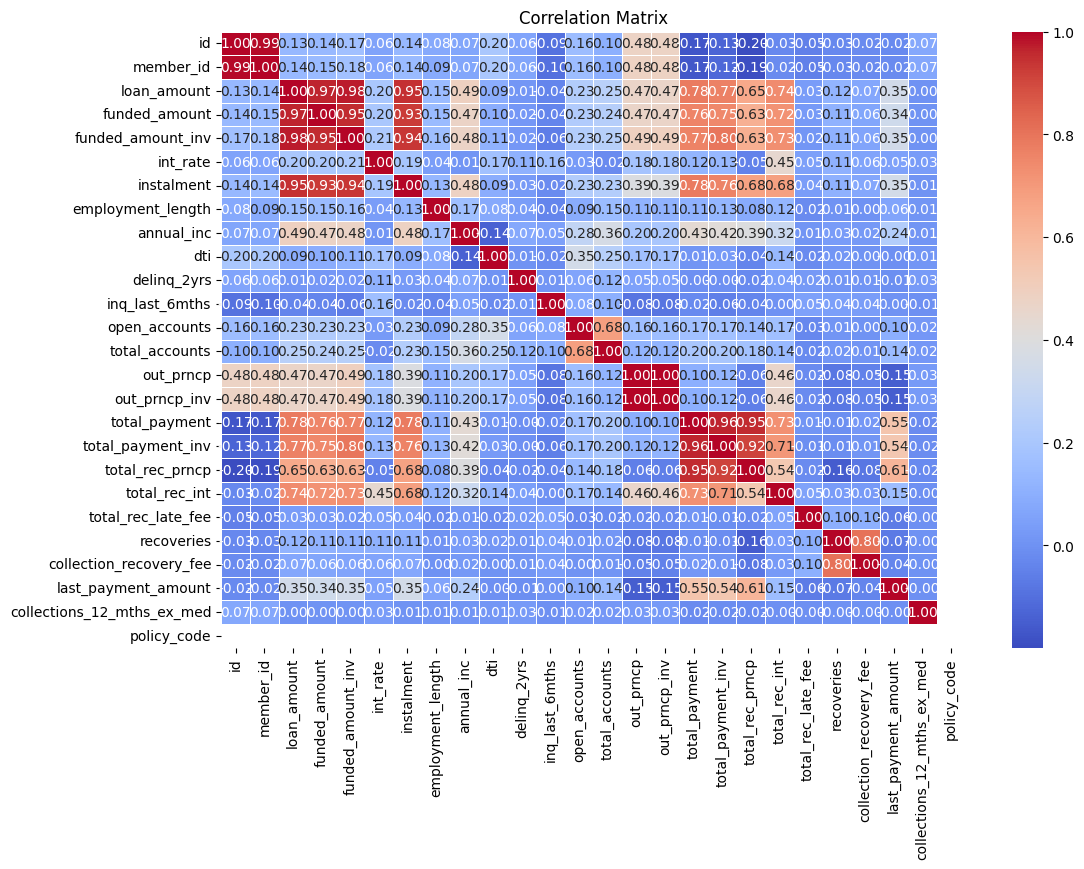

In [16]:
plotter.plot_correlation_matrix()

##### - Remove correlated data above threshold of 0.85

In [17]:
numeric_cols = custloan_df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['id', 'member_id']]
df_transform.identify_highly_correlated_columns()

Highly correlated columns (>|0.85| correlation): ['member_id', 'funded_amount', 'funded_amount_inv', 'instalment', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp']



['member_id',
 'funded_amount',
 'funded_amount_inv',
 'instalment',
 'out_prncp_inv',
 'total_payment',
 'total_payment_inv',
 'total_rec_prncp']

In [18]:
df_transform.remove_highly_correlated_columns()

Highly correlated columns (>|0.85| correlation): ['member_id', 'funded_amount', 'funded_amount_inv', 'instalment', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp']

Removed columns: ['member_id', 'funded_amount', 'funded_amount_inv', 'instalment', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp']
